# PROJET 6 : Classifiez automatiquement des biens de consommation
*Mathieu GENTHON (septembre 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Description et nettoyage du Data Set](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Classification par LDA](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Classification par NMF](#5)<a class="anchor" id="sommaire"></a>
### 6 - [Classification par VGG16](#6)<a class="anchor" id="sommaire"></a>
### 7 - [Classification par Resnet50](#7)<a class="anchor" id="sommaire"></a>
### 8 - [Classification par ORB](#8)<a class="anchor" id="sommaire"></a>
### 9 - [Regroupement des feature issues de Tf-Idf et VGG16](#9)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.
logo entreprise place de marché

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, lead data scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Vous analyserez le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité 

Contraintes :
Linda vous a communiqué la contrainte suivante : afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.


### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="2"></a>

In [504]:
# On importe les librairies dont on devrait avoir besoin pour le projet.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import nltk
#nltk.download('punkt')
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,adjusted_rand_score
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn import decomposition, cluster
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import date, time, datetime
from collections import defaultdict
from FunctionsACP import *

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None)  # On affiche tte les col des df
pd.options.display.max_rows = 100  # On affiche jusqu'à 100 lignes d'un df

In [505]:
# On charge les données depuis des fichiers en local
# et on crée des data frame pour chaque fichier.
path = 'C:/Users/GENTHON-M/Documents/formation/Open Classrooms/\
6-Classifier des articles/'

df = pd.read_csv(path+"flipkart_com-ecommerce_sample_1050.csv")

### 3 - [Description et nettoyage du data set](#3)<a class="anchor" id="3"></a>

#### 3.1 - [Description du data set](#31)<a class="anchor" id="31"></a>

In [506]:
pd.options.display.max_colwidth = 200
df.head(1)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   

                                                                                                                  product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                                                                              product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   

                                                                                                                                                                                               description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   

                                                                                                                                                                                    product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester D...

In [507]:
pd.options.display.max_colwidth = 100
print(df['uniq_id'].nunique(),
      df['product_name'].nunique(),
      df['pid'].nunique(),
      df['brand'].nunique())
print(df.shape)
cle = ['uniq_id']
df[cle].drop_duplicates().shape[0] == df.shape[0]

1050 1050 1050 490
(1050, 15)


True

3 clés primaires 'uniq_id', 'pid' et 'product_name'. Il existe 490 marques différente. Nous avons 1050 produits différents et 15 variables. Variable interessante : product_name, product_category_tree, image, description, product_specifications, brand.

In [508]:
df.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                                                                                product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...  
1  {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "val...  
2  {"product_specification"=>[{"key"=>"Material", "value"=>"Cotton Terry"}, {"key"=>"Design", "valu...

In [509]:
# On sépare la variable product_category_tree
# pour connaître la classification des produits
Class = df['product_category_tree'].str.split('>>',  expand= True)
Class['image'] = df['image']

In [511]:
# On enlève les caractères inutiles sur nos nouvelles variables
Class[0].replace('"', '', regex=True, inplace=True)
Class[0] = Class[0].str.strip('[')
Class[1].replace('"]', '', regex=True, inplace=True)
Class[2].replace('"]', '', regex=True, inplace=True)

In [512]:
# Encodage des catégories réelles
le = LabelEncoder()
Class['Class'] = le.fit_transform(Class.loc[:,0])
y_text_true = le.fit_transform(Class[0].values)
Class.head(100)

0                            1  \
0              Home Furnishing       Curtains & Accessories    
1                    Baby Care             Baby Bath & Skin    
2                    Baby Care             Baby Bath & Skin    
3              Home Furnishing                    Bed Linen    
4              Home Furnishing                    Bed Linen    
5                      Watches                Wrist Watches    
6                      Watches                Wrist Watches    
7                      Watches                Wrist Watches    
8                      Watches                Wrist Watches    
9                      Watches                Wrist Watches    
10                     Watches                Wrist Watches    
11                     Watches                Wrist Watches    
12                     Watches                Wrist Watches    
13                     Watches                Wrist Watches    
14                     Watches                Wrist Watches    
15                     Watches                Wrist Watches    
16                     Watches                Wrist Watches    
17                     Watches                Wrist Watches    
18                     Watches                Wrist Watches    
19                     Watches                Wrist Watches    
20                     Watches                Wrist Watches    
21                     Watches                Wrist Watches    
22                     Watches                Wrist Watches    
23                     Watches                Wrist Watches    
24                     Watches                Wrist Watches    
25                     Watches                Wrist Watches    
26                     Watches                Wrist Watches    
27                     Watches                Wrist Watches    
28                     Watches                Wrist Watches    
29                     Watches                Wrist Watches    
30                     Watches                Wrist Watches    
31                     Watches                Wrist Watches    
32                     Watches                Wrist Watches    
33             Home Furnishing       Living Room Furnishing    
34             Home Furnishing                    Bed Linen    
35             Home Furnishing                   Bath Linen    
36  Home Decor & Festive Needs         Candles & Fragrances    
37            Kitchen & Dining          Tableware & Cutlery    
38            Kitchen & Dining                     Lighting    
39             Home Furnishing          JMD Home Furnishing    
40                   Baby Care                  Infant Wear    
41             Home Furnishing      Kripa's Home Furnishing    
42                   Baby Care                  Infant Wear    
43    Beauty and Personal Care                    Hair Care    
44            Kitchen & Dining                  Coffee Mugs    
45            Kitchen & Dining                  Coffee Mugs    
46            Kitchen & Dining                  Coffee Mugs    
47                   Computers           Network Components    
48            Kitchen & Dining                  Coffee Mugs    
49    Beauty and Personal Care                    Hair Care    
50            Kitchen & Dining                  Coffee Mugs    
51                   Computers           Tablet Accessories    
52            Kitchen & Dining                     Cookware    
53                   Computers           Laptop Accessories    
54                   Computers           Laptop Accessories    
55                   Computers           Laptop Accessories    
56    Beauty and Personal Care                       Makeup    
57    Beauty and Personal Care              Combos and Kits    
58    Beauty and Personal Care              Combos and Kits    
59    Beauty and Personal Care              Combos and Kits    
60    Beauty and Personal Care              Combos and Kits    
61    Beauty and Personal Care              Combos and Kits   

In [513]:
print('1er niveau:', Class[0].nunique(),
      '\n2ème niveau:', Class[1].nunique(),
      '\n3ème niveau:', Class[2].nunique(), '\n') 
print(Class[0].unique(),'\n\n', Class[1].unique(),'\n\n', Class[2].unique()) 

1er niveau: 7 
2ème niveau: 63 
3ème niveau: 246 

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers '] 

 [' Curtains & Accessories ' ' Baby Bath & Skin ' ' Bed Linen '
 ' Wrist Watches ' ' Living Room Furnishing ' ' Bath Linen '
 ' Candles & Fragrances ' ' Tableware & Cutlery ' ' Lighting '
 ' JMD Home Furnishing ' ' Infant Wear ' " Kripa's Home Furnishing "
 ' Hair Care ' ' Coffee Mugs ' ' Network Components '
 ' Tablet Accessories ' ' Cookware ' ' Laptop Accessories ' ' Makeup '
 ' Combos and Kits ' ' Feeding & Nursing ' ' Baby Bedding '
 ' Kitchen & Dining Linen ' ' Containers & Bottles '
 ' Consumables & Disposables ' ' Wall Decor & Clocks '
 ' Table Decor & Handicrafts ' ' Flowers, Plants & Vases ' ' Software '
 ' Showpieces ' ' Furniture & Furnishings '
 ' Decorative Lighting & Lamps ' ' Baby Grooming '
 ' Computer Peripherals ' ' Cushions, Pillows & Covers ' ' Storage '
 ' Health Care ' ' Body 

In [514]:
# On vérifie qu'il y a une image pour chaque article
image_file_name = []
for file in sorted(os.listdir(path + 'Images')):
        image_file_name.append(file)
df['image'].isin(image_file_name).value_counts()


True    1050
Name: image, dtype: int64

In [515]:
# Pas de nom d'images en double :
df['image'].nunique()

1050

#### 3.2 - [Nettoyage](#32)<a class="anchor" id="32"></a>

In [516]:
# On supprime tout ce qui n'est pas une lettre et on met en miniscule.
df["description_clean"] = df["description"].str.replace(r"[^a-zA-Z]", " ")
df["description_clean"] = df["description_clean"].str.lower()

#### 3.3 - [Tokenisation](#33)<a class="anchor" id="33"></a>

In [517]:
from nltk import word_tokenize
# Tokens de la description (liste)
df["word_tokenized"] = df["description_clean"].apply(word_tokenize)

#### 3.4 - [Lemmatisation](#34)<a class="anchor" id="34"></a>

In [518]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GENTHON-M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\GENTHON-M\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [519]:
df['word_tokenized_lematized'] = df['word_tokenized'].apply(
                                 lambda x:[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x])

In [520]:
from nltk import FreqDist
df['freq'] = df["word_tokenized_lematized"].apply(FreqDist)

#### 3.4 - [Stop Words](#34)<a class="anchor" id="34"></a>

In [521]:
from nltk.corpus import stopwords
nltk.download('stopwords')
default_sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GENTHON-M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [522]:
# lettres seules ou dupliquées
import string
alphabet = string.ascii_lowercase
letters_stopwords = []

for letter in alphabet:
    letters_stopwords.extend([letter, letter*2, letter*3, letter*4])

In [523]:
# sum the values with same keys 
import collections, functools, operator
ini_dict = df['freq'].tolist()
text_sw_dict = dict(functools.reduce(operator.add, 
         map(collections.Counter, ini_dict))) 
  
text_sw = sorted(text_sw_dict, key=text_sw_dict.get, reverse=True)[:14]
text_sw.extend(default_sw)
text_sw.extend(letters_stopwords)

In [524]:
# On enlève tous les stop words de notre corpus.
df['word_tokenized_lematized_stop'] = df['word_tokenized_lematized'].apply(
                            lambda x: [item for item in x if item not in text_sw])
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                                                                                product_specifications  \
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...   
1  {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "val...   

                                                                                     description_clean  \
0  key features of elegance polyester multicolor abstract eyelet door curtain floral curtain elegan...   
1  specifications of sathiyas cotton bath towel    bath towel  red  yellow  blue  bath towel featur...   

                                                                                        word_tokenized  \
0  [key, features, of, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, cu...   
1  [specifications, of, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel,...   

                                                                              word_tokenized_lematized  \
0  [key, feature, of, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, cur...   
1  [specification, of, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, ...   

                                                                                                  freq  \
0  {'key': 1, 'feature': 2, 'of': 10, 'elegance': 4, 'polyester': 6, 'multicolor': 4, 'abstract': 4...   
1  {'specification': 1, 'of': 2, 'sathiyas': 3, 'cotton': 3, 'bath': 6, 'towel': 6, 'red': 2, 'yell...   

                                                                         word_tokenized_lematized_stop  
0  [key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain...  
1  [specification, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feat...

In [525]:
# Dictionnaire donnant le nombre d'apparition par mot
df['freq_tls'] = df["word_tokenized_lematized_stop"].apply(FreqDist)
# Nombre de mot par description
df['total_word'] = df["word_tokenized_lematized_stop"].apply(len)
# Nombre de mot unique par description
df['unique_word_tls'] = df["freq_tls"].apply(len)

### 4 - [Classification par LDA](#4)<a class="anchor" id="4"></a>

#### 4.1 - [Bag of Words (TF)](#41)<a class="anchor" id="41"></a>

In [526]:
# On crée une série avec les mots uniquement pour utiliser Count Vectorizer
Documents = df['word_tokenized_lematized_stop'].apply(lambda x: ' '.join(x))
Documents

0       key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...
1       specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine w...
2       key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry ...
3       key feature santosh royal fashion cotton print king size double bedsheet royal bedsheet perfact ...
4       key feature jaipur print cotton floral king size double bedsheet cotton jaipur print cotton flor...
                                                       ...                                                 
1045    oren empower extra large self adhesive sticker pack price double sticker use big wall two piece ...
1046    wallmantra large vinyl sticker sticker pack price bring home exclusive piece wall art give home ...
1047    buy uberlyfe extra large pigment polyvinyl film import sticker online uberlyfe extra large pigme...
1048    buy wallmantra mediu

In [527]:
Word_kept = 3000
Cnt_Vct = CountVectorizer(max_df=0.9, min_df=3, # Pas dans plus de 90 % des documents et 3 au mini
                          token_pattern='[a-zA-Z0-9]{3,}', # num chars > 1
                          max_features=Word_kept)

In [528]:
CountVect = Cnt_Vct.fit_transform(Documents)
CountVect

<1050x1363 sparse matrix of type '<class 'numpy.int64'>'
	with 28865 stored elements in Compressed Sparse Row format>

#### 4.2 - [LDA ](#42)<a class="anchor" id="42"></a>

In [529]:
# Define Search Param
search_params = {'learning_decay': [.5, .6, .7, .8, .9],
                #'learning_offset':[2, 6, 10, 13],
                 #'batch_size':[80, 100, 110, 128, 140, 160]
                }
n_topics = 7
# Init the Model
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        random_state=4,
        n_jobs=-1                       # Use all available CPUs
        )
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(CountVect)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=7, n_jobs=-1,
                                                 perp_tol=0.1, random_state=4,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                                 

In [530]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.5}


In [533]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(CountVect)

# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]
# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredLDA = np.argmax(df_document_topic.values, axis=1)
df_document_topic['PredLDA'] = PredLDA

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topic

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  PredLDA
Doc0       0.07    0.21    0.00    0.10    0.00    0.61    0.00        5
Doc1       0.00    0.73    0.00    0.00    0.03    0.23    0.00        1
Doc2       0.21    0.40    0.00    0.08    0.05    0.27    0.00        1
Doc3       0.00    0.95    0.00    0.00    0.00    0.00    0.04        1
Doc4       0.00    0.99    0.00    0.00    0.00    0.00    0.00        1
...         ...     ...     ...     ...     ...     ...     ...      ...
Doc1045    0.00    0.00    0.01    0.98    0.00    0.00    0.00        3
Doc1046    0.00    0.00    0.00    0.64    0.00    0.36    0.00        3
Doc1047    0.01    0.01    0.56    0.41    0.01    0.01    0.01        2
Doc1048    0.01    0.01    0.53    0.44    0.01    0.01    0.01        2
Doc1049    0.01    0.01    0.62    0.34    0.01    0.01    0.01        2

[1050 rows x 8 columns]

In [534]:
df_topic_distribution = df_document_topic['PredLDA'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          2            467
1          1            207
2          4            112
3          5             93
4          3             69
5          0             58
6          6             44

#### 4.3 - [Matrice de confusion et indice de Rand ajusté](#43)<a class="anchor" id="43"></a>

In [535]:
def plot_confusion_matrix(y_pred, y_true, classesx, classesy, normalize=False, title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrixHDB
    cm = confusion_matrix(y_pred, y_true)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.xticks(rotation=90)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classesx, yticklabels=classesy,
           title=title,
           xlabel='True label',
           ylabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


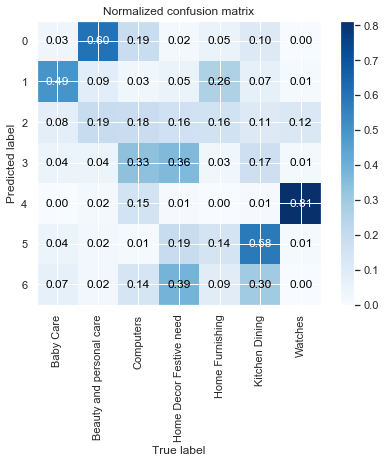

In [536]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
Classx = ['Baby Care', 'Beauty and personal care', 'Computers',
         'Home Decor Festive need', 'Home Furnishing', 'Kitchen Dining',
         'Watches']
label = Class['Class']

plot_confusion_matrix(PredLDA, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [537]:
ari = adjusted_rand_score(label, PredLDA)
ari

0.11172953154605895

#### 4.4 - [Visualisation par Word Cloud](#44)<a class="anchor" id="44"></a>

Topic 0:


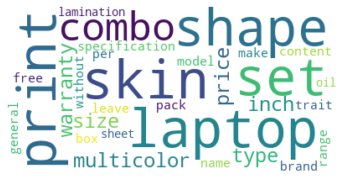

Topic 1:


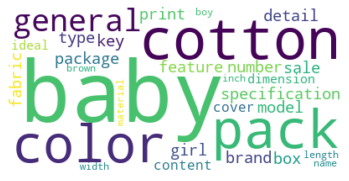

Topic 2:


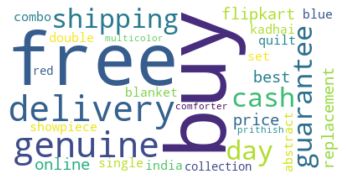

Topic 3:


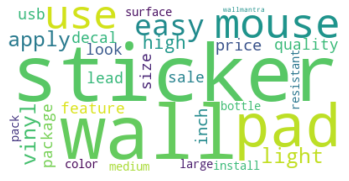

Topic 4:


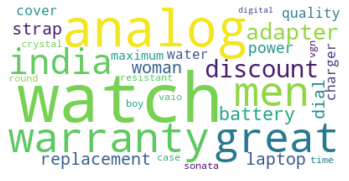

Topic 5:


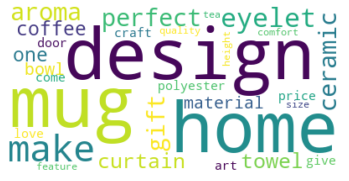

Topic 6:


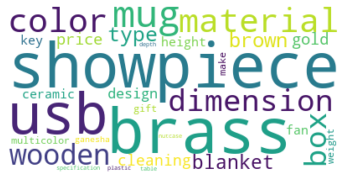

In [538]:
def display_topics_wordcloud(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        text = (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        wordcloud = WordCloud(background_color="white").generate(text)

        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

no_top_words = 30
display_topics_wordcloud(best_lda_model, Cnt_Vct.get_feature_names(), no_top_words)


#### 4.5 - [Visualisation par t-SNE](#45)<a class="anchor" id="45"></a>

In [539]:
tsne_LDA = TSNE(n_jobs=-1, perplexity=120)
X_tsne_LDA = tsne_LDA.fit_transform(CountVect)

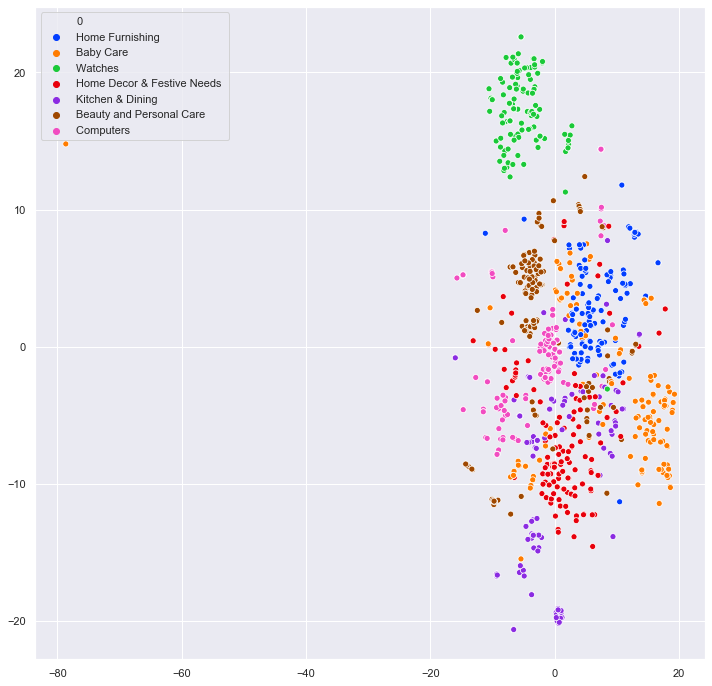

In [540]:
fig = plt.figure(figsize=(12, 12))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_LDA[:, 0], X_tsne_LDA[:, 1],
                hue=Class[0], legend='full', palette=pal)

#### 4.6 - [K-Means après réduction par LDA](#46)<a class="anchor" id="46"></a>

In [541]:
df_LDA = df_document_topic.drop(['PredLDA'], axis=1)
km_LDA = cluster.KMeans(n_clusters=7)
km_LDA.fit(df_LDA)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [542]:
tsne_km_LDA = TSNE(n_jobs=-1, perplexity=20)
X_tsne_km_LDA = tsne_km_LDA.fit_transform(df_document_topic)

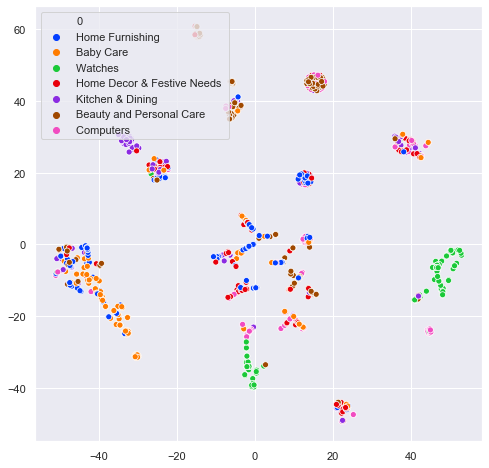

In [543]:
km_LDA_label = km_LDA.labels_
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_km_LDA[:, 0], X_tsne_km_LDA[:, 1],
                hue=Class[0], legend='full', palette=pal)

Normalized confusion matrix


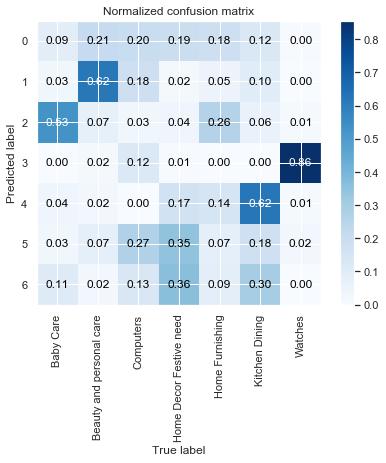

In [544]:
plot_confusion_matrix(km_LDA_label, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [545]:
ari_km_LDA = adjusted_rand_score(label, km_LDA_label)
ari_km_LDA

0.20203399712343767

### 5 - [Classification par NMF](#5)<a class="anchor" id="5"></a>

#### 5.1 - [TF-IDF](#51)<a class="anchor" id="51"></a>

In [546]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, 
                                   min_df=3, 
                                   max_features=Word_kept,
                                   token_pattern= '[a-zA-Z]{3,}'
                                   )
tfidf = tfidf_vectorizer.fit_transform(Documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tf_idf_to_df = tfidf.todense()

In [547]:
df_tfidf = pd.DataFrame(tf_idf_to_df)
df_tfidf

0    1    2    3        4    5    6    7    8    9   10   11   12  \
0     0.0  0.0  0.0  0.0  0.17863  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...      ...  ...  ...  ...  ...  ...  ...  ...  ...   
1045  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1046  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1047  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1048  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1049  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       13   14        15   16   17   18   19   20   21   22   23   24  \
0     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1045  0.0  0.0  0.042778  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1046  0.0  0.0  0.121179  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1047  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1048  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1049  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            25   26   27        28   29   30   31   32        33   34   35  \
0     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
2     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
3     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
4     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
...        ...  ...  ...       ...  ...  ...  ...  ...       ...  ...  ...   
1045  0.079123  0.0  0.0  0.083655  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1046  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.075055  0.0  0.0   
1047  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1048  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1049  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

       36        37   38   39   40   41   42   43   44        45        46  \
0     0.0  0.070697  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.070697   
1     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
2     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
3     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
4     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
...   ...       ...  ...  ...  ...  ...  ...  ...  ...       ...       ...   
1045  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.085555  0.000000   
1046  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1047  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1048  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1049  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   

            47   48   49   50   51        52   53   54   55        56   57  \
0     0.060839  0.0  0.0  0.0  0.0  0.058878  0.0  0.0  0.0  0.000000  0.0   
1     0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0   
2     0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0   
3     0.000000  0.0 

#### 5.2 - [Factorisation de matrice non négative (NMF)](#52)<a class="anchor" id="52"></a>

In [548]:
# Define NMF
nmf = NMF(n_components=n_topics,
          random_state=1,
          init='nndsvd',
          alpha=0.1,
          l1_ratio=0.5
         )

nmf_output = nmf.fit_transform(tfidf)

In [549]:
##### column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]

# Make the pandas dataframe
df_document_topic_nmf = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredNMF = np.argmax(df_document_topic_nmf.values, axis=1)
df_document_topic_nmf['PredNMF'] = PredNMF
df_document_topic_nmf

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  PredNMF
Doc0       0.00     0.0    0.00    0.01    0.00    0.12    0.03        5
Doc1       0.01     0.0    0.05    0.00    0.00    0.09    0.00        5
Doc2       0.02     0.0    0.05    0.00    0.00    0.08    0.00        5
Doc3       0.00     0.0    0.02    0.00    0.00    0.13    0.02        5
Doc4       0.00     0.0    0.02    0.00    0.00    0.13    0.02        5
...         ...     ...     ...     ...     ...     ...     ...      ...
Doc1045    0.00     0.0    0.00    0.00    0.00    0.02    0.00        5
Doc1046    0.00     0.0    0.00    0.02    0.00    0.06    0.00        5
Doc1047    0.02     0.0    0.00    0.00    0.05    0.00    0.00        4
Doc1048    0.01     0.0    0.00    0.00    0.05    0.00    0.00        4
Doc1049    0.02     0.0    0.00    0.00    0.07    0.00    0.00        4

[1050 rows x 8 columns]

#### 5.3 - [Matrice de confusion et indice de Rand ajusté](#53)<a class="anchor" id="53"></a>

Normalized confusion matrix


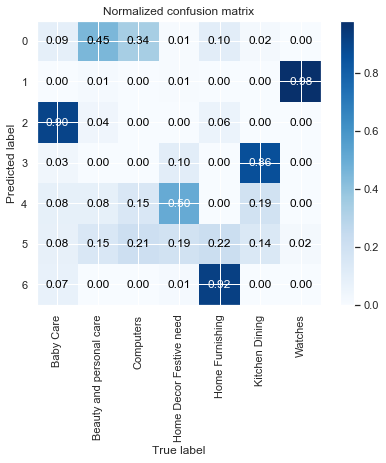

In [550]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
label = Class['Class']

plot_confusion_matrix(PredNMF, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [551]:
ari_NMF = adjusted_rand_score(label, PredNMF)
ari_NMF

0.32744985616958927

#### 5.4 - [WordCloud](#54)<a class="anchor" id="54"></a>

Topic 0:


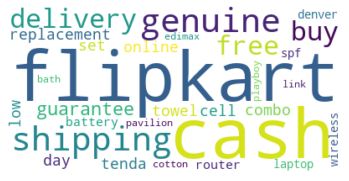

Topic 1:


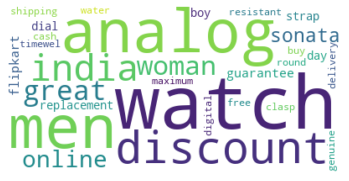

Topic 2:


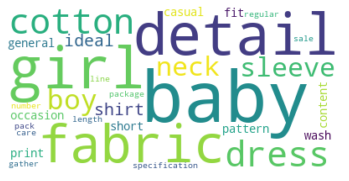

Topic 3:


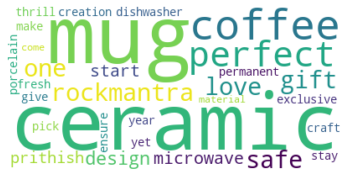

Topic 4:


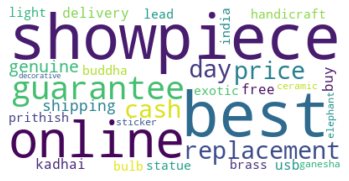

Topic 5:


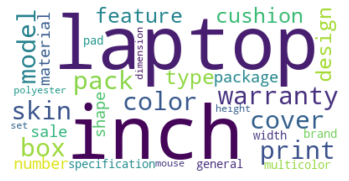

Topic 6:


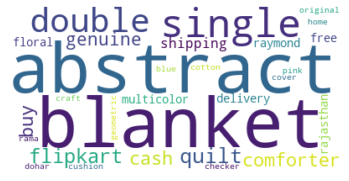

In [552]:
display_topics_wordcloud(nmf, tfidf_vectorizer.get_feature_names(), no_top_words)

#### 5.5 - [t-SNE](#55)<a class="anchor" id="55"></a>

In [553]:
tsne_NMF = TSNE(n_jobs=-1, perplexity=120)
X_tsne_NMF = tsne_NMF.fit_transform(tfidf)

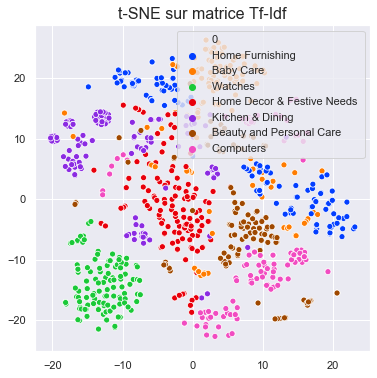

In [554]:
fig = plt.figure(figsize=(6, 6))
plt.title("t-SNE sur matrice Tf-Idf", size=16)
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_NMF[:, 0], X_tsne_NMF[:, 1],
                hue=Class[0], legend='full', palette=pal)

#### 5.6 - [Sparse PCA](#56)<a class="anchor" id="56"></a>

In [555]:
pca = decomposition.SparsePCA()
pca.fit(tfidf.toarray())

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
          n_components=None, n_jobs=None, normalize_components='deprecated',
          random_state=None, ridge_alpha=0.01, tol=1e-08, verbose=False)

In [556]:
X_ACP = pd.DataFrame(pca.transform(tfidf.toarray()))
X_ACP

0         1         2         3         4         5         6  \
0    -0.168016  0.065757 -0.031993 -0.094114 -0.024904  0.021483 -0.009506   
1    -0.168016  0.055891 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
2    -0.168016  0.060636 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
3    -0.168016  0.065757 -0.031993 -0.094114 -0.024783  0.021483 -0.009506   
4    -0.168016  0.065757 -0.031993 -0.094114 -0.024967  0.021483 -0.009506   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.160777  0.065757 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
1046 -0.168016  0.065757 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
1047  0.042608  0.065757 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
1048  0.011562  0.065757 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   
1049  0.102520  0.065757 -0.031993 -0.094114 -0.025654  0.021483 -0.009506   

             7         8         9        10   11   12        13        14  \
0     0.001061 -0.019888  0.019484 -0.031774  0.0  0.0  0.009764 -0.013135   
1    -0.029379  0.685399  0.019484 -0.031774  0.0  0.0  0.009764 -0.013135   
2     0.187852  0.556212  0.019484 -0.031774  0.0  0.0  0.009764 -0.013135   
3    -0.029379  0.007615  0.019484 -0.031774  0.0  0.0  0.009764  0.211296   
4    -0.029379  0.012666  0.019484 -0.031774  0.0  0.0  0.009764  0.163962   
...        ...       ...       ...       ...  ...  ...       ...       ...   
1045 -0.029379 -0.019888  0.019484 -0.031774  0.0  0.0  0.009764 -0.013135   
1046 -0.029379 -0.019888  0.019484 -0.026324  0.0  0.0  0.009764 -0.013135   
1047 -0.029379 -0.019888  0.019484 -0.020234  0.0  0.0  0.009764 -0.013135   
1048 -0.029379 -0.019888  0.019484 -0.021935  0.0  0.0  0.009764 -0.013135   
1049 -0.029379 -0.019888  0.019484 -0.016951  0.0  0.0  0.009764 -0.013135   

            15       16        17        18        19        20        21  \
0    -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
1     0.048047  0.01193  0.012049  0.009434  0.051207  0.015652 -0.011189   
2     0.013152  0.01193  0.012049 -0.040046  0.017177  0.015652 -0.011189   
3    -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
4    -0.024519  0.01193 -0.025358  0.009434 -0.019559  0.015652 -0.011189   
...        ...      ...       ...       ...       ...       ...       ...   
1045 -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
1046 -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
1047 -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
1048 -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   
1049 -0.024519  0.01193  0.012049  0.009434 -0.019559  0.015652 -0.011189   

       22        23   24        25        26        27   28       29  \
0     0.0 -0.008076  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
1     0.0 -0.008076  0.0  0.010965 -0.006341  0.053725  0.0 -0.00737   
2     0.0 -0.008076  0.0  0.010965 -0.006341  0.018830  0.0 -0.00737   
3     0.0 -0.008076  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
4     0.0 -0.008076  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
...   ...       ...  ...       ...       ...       ...  ...      ...   
1045  0.0  0.231927  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
1046  0.0  0.186174  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
1047  0.0  0.403236  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
1048  0.0  0.693295  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   
1049  0.0  0.520234  0.0  0.010965 -0.006341 -0.018841  0.0 -0.00737   

            30   31   32   33   34   35        36        37        38  \
0    -0.006429  0.0  0.0  0.0  0.0  0.0  0.005804  0.004708  0.012007   
1    -0.006429  0.0  0.0  0.0  0.0  0.0  0.005804  0.004708  0.012007   
2    -0.006429  0.0  0.0  0.0  0.0  0.0  0.005804  0.004708  0.012007   
3    -0.006429  0.0  0.0  0.0  0.0  0.0  0.005804  0.0047

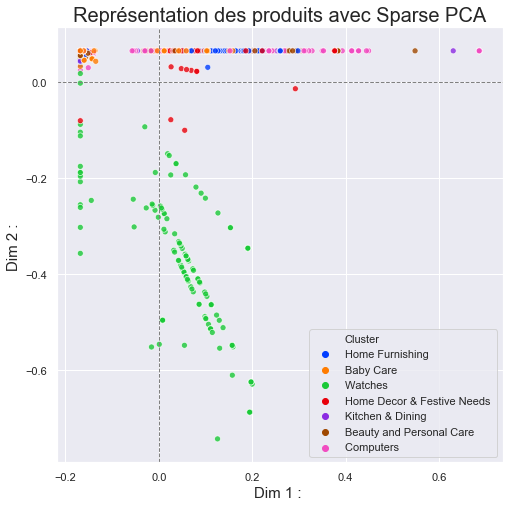

In [567]:
# Transformation en DataFrame pandas
df_PCA = pd.DataFrame({ "Dim1" : X_ACP.iloc[:,0], 
                        "Dim2" : X_ACP.iloc[:,1],
                        "Dim3" : X_ACP.iloc[:,2], 
                        "Dim4" : X_ACP.iloc[:,3],
  
                        "Cluster" : Class[0]
                       })

fig = plt.figure(figsize=(8, 8))
g_pca = sns.scatterplot(x="Dim1", y="Dim2", data = df_PCA,
                        hue = "Cluster", palette='bright', alpha=0.8)
plt.title("Représentation des produits avec Sparse PCA", size=20)
g_pca.set_xlabel("Dim 1 : ", fontsize=15)
g_pca.set_ylabel("Dim 2 : ", fontsize=15)
plt.axvline(color='gray', linestyle='--', linewidth=1)
plt.axhline(color='gray', linestyle='--', linewidth=1)

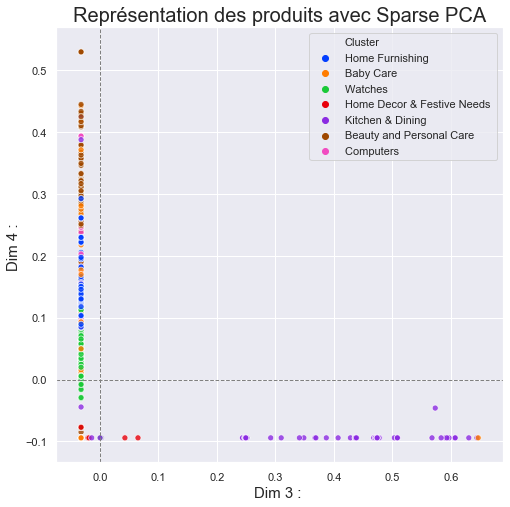

In [568]:
fig = plt.figure(figsize=(8, 8))
g_pca = sns.scatterplot(x="Dim3", y="Dim4", data = df_PCA,
                        hue = "Cluster", palette='bright', alpha=0.8)
plt.title("Représentation des produits avec Sparse PCA", size=20)
g_pca.set_xlabel("Dim 3 : ", fontsize=15)
g_pca.set_ylabel("Dim 4 : ", fontsize=15)
plt.axvline(color='gray', linestyle='--', linewidth=1)
plt.axhline(color='gray', linestyle='--', linewidth=1)

#### 5.7 - [k-Means après NMF](#57)<a class="anchor" id="57"></a>

In [558]:
df_NMF = df_document_topic_nmf.drop(['PredNMF'], axis=1)
km_NMF = cluster.KMeans(n_clusters=7)
km_NMF.fit(df_NMF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [559]:
tsne_km_NMF = TSNE(n_jobs=-1, perplexity=50)
X_tsne_km_NMF = tsne_km_LDA.fit_transform(df_document_topic_nmf)

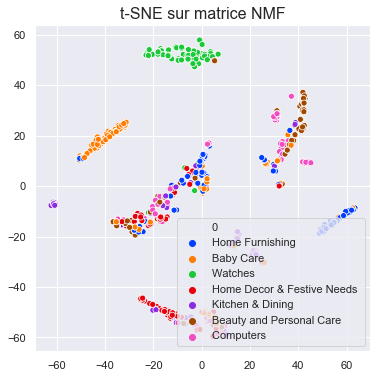

In [560]:
km_NMF_label = km_NMF.labels_
fig = plt.figure(figsize=(6, 6))
plt.title("t-SNE sur matrice NMF", size=16)
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_km_NMF[:, 0], X_tsne_km_NMF[:, 1],
                hue=Class[0], legend='full', palette=pal)

Normalized confusion matrix


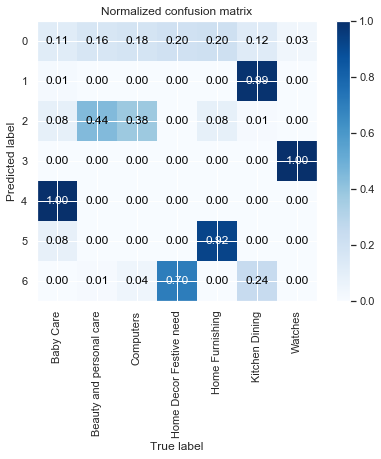

In [561]:
plot_confusion_matrix(km_NMF_label, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [562]:
ari_km_NMF = adjusted_rand_score(label, km_NMF_label)
ari_km_NMF

0.237781786209306

### 6 - [Classification avec réseau VGG 16](#6)<a class="anchor" id="6"></a>

#### 6.1 - [Extraction de feature avec VGG](#61)<a class="anchor" id="61"></a>

In [563]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# remove 2 output layer to use the vgg16 model as a feature extraction model (4096)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [564]:
features_list = []
for i in range(1050):
    # load an image from file
    image = load_img(path + 'Images/'+ df.loc[i, 'image'], target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    # reduce dimension of array to 1D
    features = np.ravel(features)
    features_list.append(features)

df_vgg16 = pd.DataFrame.from_records(features_list)
df_vgg16.head()   

C:\anaconda\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


0         1    2         3         4         5         6    7    8  \
0  3.398614  0.859572  0.0  1.106560  2.266122  2.927241  2.446448  0.0  0.0   
1  0.000000  0.000000  0.0  1.172009  0.000000  0.000000  0.000000  0.0  0.0   
2  0.000000  0.000000  0.0  4.457807  0.000000  0.000000  0.000000  0.0  0.0   
3  0.000000  0.070991  0.0  2.046283  0.000000  0.000000  0.000000  0.0  0.0   
4  3.417152  0.000000  0.0  0.000000  1.012359  0.000000  0.000000  0.0  0.0   

          9        10   11        12   13        14   15        16        17  \
0  0.000000  0.000000  0.0  0.000000  0.0  0.559278  0.0  0.000000  0.000000   
1  6.499799  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.594588  2.796111   
2  2.820566  0.000000  0.0  0.000000  0.0  0.000000  0.0  4.381300  0.457951   
3  0.894023  0.754701  0.0  0.365444  0.0  0.000000  0.0  0.000000  0.000000   
4  0.000000  0.000000  0.0  1.936730  0.0  0.000000  0.0  0.000000  0.000000   

         18        19        20        21        22        23        24  \
0  0.246030  1.012809  4.723428  0.000000  0.000000  0.000000  1.527076   
1  0.000000  0.998302  0.000000  0.000000  0.474827  0.000000  0.000000   
2  0.000000  1.172502  0.000000  0.000000  0.000000  2.119234  0.000000   
3  0.000000  0.000000  0.000000  0.506435  2.758231  0.000000  0.000000   
4  0.502926  1.837902  0.307346  0.000000  0.154491  0.000000  0.000000   

         25        26         27   28        29   30        31   32       33  \
0  0.000000  1.475293   0.727806  0.0  0.000000  0.0  1.122839  0.0  0.00000   
1  0.000000  0.000000  12.447859  0.0  0.228286  0.0  3.627892  0.0  0.00000   
2  0.000000  0.000000   0.175475  0.0  0.089589  0.0  0.000000  0.0  0.00000   
3  0.000000  0.210387   3.579496  0.0  0.026015  0.0  0.000000  0.0  1.03606   
4  4.073332  0.000000   3.148693  0.0  0.000000  0.0  0.000000  0.0  0.00000   

    34        35        36        37   38   39        40        41   42  \
0  0.0  3.408424  1.094498  1.497917  0.0  0.0  2.367992  2.372085  0.0   
1  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.0   
2  0.0  0.000000  0.000000  1.647263  0.0  0.0  0.000000  1.841473  0.0   
3  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  2.069361  0.0   
4  0.0  2.132993  0.000000  2.182173  0.0  0.0  0.047696  0.000000  0.0   

         43   44        45        46        47   48        49   50   51   52  \
0  2.984934  0.0  6.419508  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
1  3.319997  0.0  0.000000  1.058609  0.000000  0.0  4.110573  0.0  0.0  0.0   
2  3.759655  0.0  0.000000  0.877832  0.000000  0.0  0.000000  0.0  0.0  0.0   
3  3.707276  0.0  0.000000  0.000000  1.222202  0.0  0.757769  0.0  0.0  0.0   
4  2.694549  0.0  2.830708  3.845765  0.000000  0.0  0.000000  0.0  0.0  0.0   

         53        54   55   56        57        58        59        60   61  \
0  0.000000  0.000000  0.0  0.0  2.067128  0.000000  0.000000  0.000000  0.0   
1  0.276897  0.234287  0.0  0.0  0.000000  2.713845  7.922613  0.000000  0.0   
2  0.801307  2.207544  0.0  0.0  0.318712  1.571629  3.804740  0.000000  0.0   
3  0.000000  0.000000  0.0  0.0  0.000000  2.671739  0.473501  0.598631  0.0   
4  0.000000  0.000000  0.0  0.0  0.000000  0.233287  0.000000  0.237471  0.0   

         62   63        64        65        66   67   68   69   70   71   72  \
0  1.577005  0.0  0.000000  3.286894  0.891427  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.000000  0.0  0.000000  4.806359  3.012152  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.000000  0.0  1.274671  0.242839  5.872327  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.000000  0.0  0.000000  0.340575  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.000000  0.0  0.000000  0.000000  0.748749  0.0  0.0  0.0  0.0  0.0  0.0   

    73   74   75        76        77   78        79   80        81        82  \
0  0.0  0.0  0.0  0.008177  0.000000  0.0  1.953498  0.0  1.867274  0.000000   
1  0.0  0.0  0.0  0.000000  1.148199  0.0  0.000000  0.0  0.00

#### 6.2 - [Factorisation de matrice non négative (NMF)](#62)<a class="anchor" id="62"></a>

In [569]:
# Use NMF to cluster feature extracted by VGG16.
nmf_output = nmf.fit_transform(df_vgg16)
nmf_output.shape

(1050, 7)

In [570]:
# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]

# Make the pandas dataframe
df_vgg16_nmf = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredNMF = np.argmax(df_vgg16_nmf.values, axis=1)
df_vgg16_nmf['PredNMF'] = PredNMF

#### 6.3 - [Visualisation par t-SNE](#63)<a class="anchor" id="63"></a>

In [571]:
tsne_VGG = TSNE(n_jobs=-1, perplexity=120)
X_tsne_VGG = tsne_LDA.fit_transform(df_vgg16)

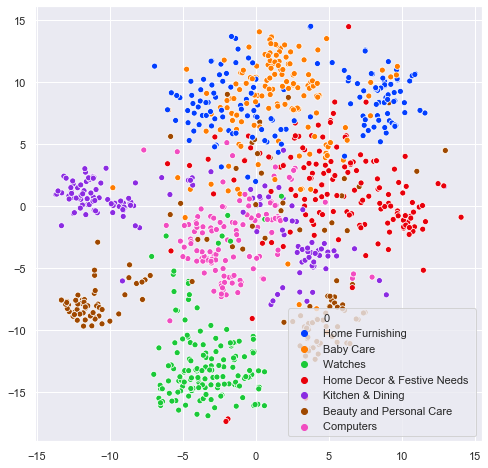

In [572]:
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_VGG[:, 0], X_tsne_VGG[:, 1],
                hue=Class[0], legend='full', palette=pal)

#### 6.4 - [Matrice de confusion](#64)<a class="anchor" id="64"></a>

Normalized confusion matrix


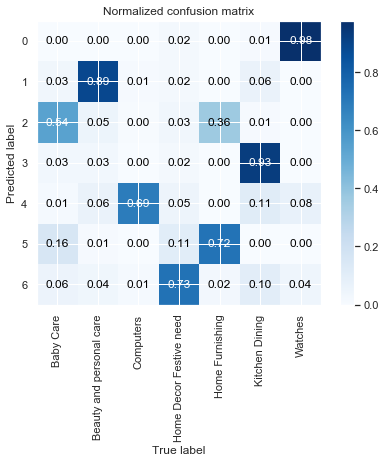

In [573]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
label = Class['Class']

plot_confusion_matrix(PredNMF, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

#### 6.5 - [ARI](#65)<a class="anchor" id="65"></a>

In [574]:
ari_VGG_NMF = adjusted_rand_score(label, PredNMF)
ari_VGG_NMF

0.542094066934703

#### 6.6 - [k-Means sur résultat NMF](#66)<a class="anchor" id="66"></a>

In [575]:
df_vgg16_nmf = df_vgg16_nmf.drop(['PredNMF'], axis=1)
km_NMF.fit(df_vgg16_nmf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [576]:
km_NMF_label = km_NMF.labels_

In [577]:
ari_km_NMF = adjusted_rand_score(label, km_NMF_label)
ari_km_NMF

0.4552468550625772

### 7 - [Classification avec réseau Resnet50](#7)<a class="anchor" id="7"></a>

#### 7.1 - [Extraction de feature avec Resnet50](#71)<a class="anchor" id="71"></a>

In [578]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

model_ResNet2 = ResNet50(weights='imagenet')

In [579]:
# remove the output layer to use the resnet model as a feature extraction model
model = Model(inputs=model_ResNet2.inputs, outputs=model_ResNet2.layers[-2].output)

In [580]:
features_list = []
for i in range(1050):
    # load an image from file
    image = load_img(path + 'Images/'+ df.loc[i, 'image'], target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the Resnet model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    # reduce dimension of array to 1D
    features = np.ravel(features)
    features_list.append(features)

df_resnet = pd.DataFrame.from_records(features_list)
df_resnet.head() 

C:\anaconda\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


0         1         2         3         4         5         6  \
0  1.345140  0.201779  0.078636  0.355285  0.258415  0.385374  0.303667   
1  0.000000  0.000000  0.075165  0.000000  0.430234  0.024912  0.113968   
2  0.000295  0.641398  0.686601  0.235372  0.340906  0.475869  0.945111   
3  0.000000  0.085551  0.028265  0.010582  0.020394  0.012733  0.156713   
4  0.574490  0.603914  0.471239  0.133124  1.581615  0.122155  0.118328   

          7         8         9        10        11        12        13  \
0  0.353998  0.759284  2.303593  1.530846  0.105421  0.204132  0.132535   
1  0.637757  0.000000  0.707669  2.119422  0.012026  1.436058  1.315993   
2  0.752008  0.022733  0.000000  1.200556  0.270310  0.996907  0.337059   
3  0.691370  0.062893  2.232237  0.499204  0.319333  0.000000  0.393783   
4  0.105177  0.340426  3.023386  0.689441  0.000000  0.028801  0.468477   

         14        15        16        17        18        19        20  \
0  0.295884  0.446580  0.000000  0.123328  0.012714  1.335660  0.236527   
1  0.014071  0.779890  0.000000  0.054160  0.000000  0.018525  0.305619   
2  0.639978  0.000000  0.000000  0.003946  0.006659  0.231253  0.518800   
3  0.288206  0.000000  0.061269  0.000000  0.009509  0.163936  0.295282   
4  0.078642  0.639411  0.041926  0.132126  0.323980  0.504585  3.297021   

         21        22        23        24        25        26        27  \
0  0.015273  0.043822  0.243754  0.027012  0.026983  0.957306  0.487584   
1  0.000000  0.000000  0.678222  0.359975  0.215636  0.075394  0.531889   
2  0.090597  0.527353  0.936463  0.067911  0.049215  0.215946  0.417127   
3  0.176243  0.000000  1.168514  0.104156  0.030921  2.285336  0.132033   
4  0.689200  0.000000  0.280390  0.972236  0.096506  1.902265  0.163480   

         28        29        30        31        32        33        34  \
0  0.205992  0.013268  0.000000  0.237845  1.173149  0.140957  0.327352   
1  0.135579  3.733550  0.193946  0.345811  0.177102  0.133516  0.995566   
2  0.058409  0.034999  0.292780  0.319506  0.266012  1.103816  1.648330   
3  0.006309  0.173299  0.027439  0.065760  0.074817  0.437163  0.921566   
4  0.009858  0.024555  0.182617  0.153749  0.116090  1.590540  0.128756   

         35        36         37        38        39        40        41  \
0  0.493388  0.519379  11.398900  0.029051  0.102491  0.003247  0.007192   
1  0.349263  0.149325   0.981123  0.010483  0.000000  0.278279  0.471779   
2  0.000000  0.111922   2.642602  0.000000  0.040960  0.055768  0.044896   
3  0.000000  0.153899   2.818457  0.013543  0.000000  0.936353  0.433538   
4  0.265706  0.383494   5.553537  0.000000  0.419438  0.010068  0.049273   

         42        43        44        45        46        47        48  \
0  0.005604  0.071035  0.593940  1.106724  0.191945  0.097747  0.160458   
1  0.000000  0.599315  0.329039  0.008371  1.097035  0.077497  0.000000   
2  0.429032  1.470387  0.058870  0.503410  0.022968  0.001940  0.000000   
3  0.000000  0.294398  0.061647  0.296017  1.953177  0.169831  0.000000   
4  0.000024  0.721951  0.392974  1.020672  0.696710  2.219433  0.312504   

         49        50        51        52        53        54        55  \
0  1.150820  0.056332  0.000714  0.419451  1.093880  0.029703  0.406371   
1  2.321216  0.000000  0.000000  0.092482  0.673799  0.305930  0.207406   
2  8.186884  0.442656  0.011029  0.727966  0.191609  4.009353  0.000000   
3  1.193462  0.017718  0.000000  0.670184  0.112064  0.239611  0.000000   
4  3.799345  0.000000  0.015780  0.166578  0.426065  0.410731  1.120008   

         56        57        58        59        60       61        62  \
0  0.095144  1.448575  0.175604  0.627697  2.603275  0.02764  0.020902   
1  0.056805  0.330272  0.141312  1.096340  0.012798  0.00000  0.623814   
2  0.000000  0.590278  0.266431  0.034189  0.029614  0.00000  0.244304   
3  0.000000  0.136462  0.153875  0.835398  0.147282  0.00000  0.597492   
4  0.029968  0.020955  0.1

#### 7.2 - [Factorisation de matrice non négative (NMF)](#72)<a class="anchor" id="72"></a>

In [581]:
# Use NMF to cluster feature extracted by Resnet50.
nmf_output_resnet = nmf.fit_transform(df_resnet)
nmf_output_resnet.shape

(1050, 7)

In [582]:
# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]

# Make the pandas dataframe
df_resnet_nmf = pd.DataFrame(np.round(nmf_output_resnet, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredNMF = np.argmax(df_resnet_nmf.values, axis=1)
df_resnet_nmf['PredNMF'] = PredNMF

#### 7.3 - [Visualisation par t-SNE](#73)<a class="anchor" id="73"></a>

In [583]:
tsne_resnet = TSNE(n_jobs=-1, perplexity=120)
X_tsne_resnet = tsne_LDA.fit_transform(df_resnet)

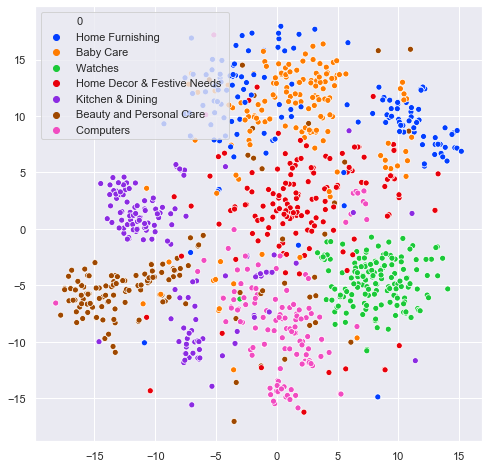

In [584]:
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_resnet[:, 0], X_tsne_resnet[:, 1],
                hue=Class[0], legend='full', palette=pal)

#### 7.4 - [Matrice de confusion](#74)<a class="anchor" id="74"></a>

Normalized confusion matrix


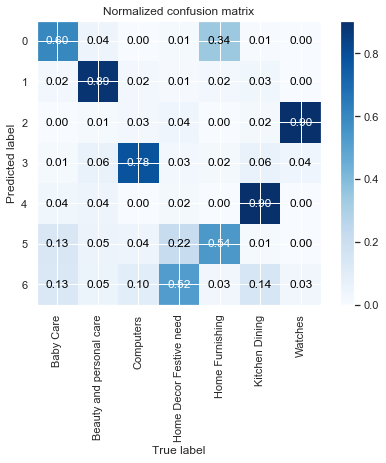

In [585]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
label = Class['Class']

plot_confusion_matrix(PredNMF, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

#### 7.5 - [ARI](#75)<a class="anchor" id="75"></a>

In [586]:
ari_resnet_NMF = adjusted_rand_score(label, PredNMF)
ari_resnet_NMF

0.47811574902311355

#### 7.6 - [k-Means sur résultat NMF](#76)<a class="anchor" id="76"></a>

In [587]:
df_resnet_nmf = df_resnet_nmf.drop(['PredNMF'], axis=1)
km_NMF.fit(df_resnet_nmf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [588]:
km_NMF_label = km_NMF.labels_
ari_km_NMF = adjusted_rand_score(label, km_NMF_label)
ari_km_NMF

0.4314083553307002

### 8 - [Classification avec ORB](#8)<a class="anchor" id="8"></a>

In [589]:
import cv2
from sklearn.cluster import KMeans

In [590]:
# Get ORB descriptors from images and train a k-means classifier    
def read_and_clusterize(folder, num_cluster):

    features_list_ORB = []
    # Initiate ORB
    orb = cv2.ORB_create()
    
    for filename in os.listdir(folder):
        
        # read image and convert grey scale
        path = folder + "/" + filename
        img = cv2.imread(path,0)
        # Resize if Height or Width > 500
        if (img.shape[0] > 500 | img.shape[1] > 500):
            aspect_ratio = float(img.shape[1]) / float(img.shape[0])
            window_height = img.shape[1]
            window_width = window_height / aspect_ratio
            img = cv2.resize(img, (int(window_height), int(window_width)))  
        
        # ORB Descriptors and append the descriptors to a list of descriptors
        kp, des = orb.detectAndCompute(img,None)
        des = np.asarray(des)
        for d in des:
            features_list_ORB.append(d)       
        
    #with the descriptors detected, lets clusterize them
    print("Training kmeans")    
     
    kmeans = KMeans(n_clusters = num_cluster, n_init=6)
    kmeans.fit(features_list_ORB)
    visual_words = kmeans.cluster_centers_
    return kmeans

In [591]:
def calculate_centroids_histogram(folder, model, num_clusters):
    Images = []
    feature_vectors=[]
    n_d_ORB = []
        
    # Initiate ORB
    orb = cv2.ORB_create()
    
    for filename in os.listdir(folder):
             
        #read image and convert grey scale
        path = folder + "/" + filename
        img = cv2.imread(path,0)
                
        # ORB Descriptors and append the descriptors to a list of descriptors
        kp, des = orb.detectAndCompute(img,None)
        des = np.asarray(des)
        for d in des:
            n_d_ORB.append(d)

        #classification of all descriptors in the model
        predict_kmeans=model.predict(des)
        #calculates the histogram
        hist, bin_edges=np.histogram(predict_kmeans, bins=num_clusters)
        #histogram is the feature vector
        feature_vectors.append(hist)
        Images.append(filename)
    # Nombre de descripteurs ORB
    print("Nombre de descripteurs ORB :", len(n_d_ORB))
    feature_vectors=np.asarray(feature_vectors)
    
    #return vectors and 
    return feature_vectors, Images

In [592]:
N_Cluster = 70
print("Step 1: Calculating Kmeans classifier")
model = read_and_clusterize(path + 'Images',N_Cluster)

print("Step 2: Extracting histograms images")
train_featvec, Images = calculate_centroids_histogram(path + 'Images',model, N_Cluster)
print(train_featvec)
print(train_featvec.shape)

Step 1: Calculating Kmeans classifier
Training kmeans
Step 2: Extracting histograms images
Nombre de descripteurs ORB : 503972
[[14  4  3 ... 12 26  2]
 [ 9  3  4 ...  2  9  2]
 [15  9  0 ...  0  0 38]
 ...
 [ 5  2  5 ...  0 11  5]
 [13  7  9 ...  5 10  7]
 [10  5  6 ...  2  0 56]]
(1050, 70)


In [593]:
# Make dataframe from BoVW.
df_ORB = pd.DataFrame.from_records(train_featvec, index = Images)
df_ORB_merged = pd.merge(Class, df_ORB, left_on='image', right_index=True)
df_ORB_merged.drop(['0_x', '1_x', '2_x', '3_x',
                   '4_x', '5_x', '6_x', 'image', 'Class'],axis=1, inplace=True)

In [594]:
# Use NMF to cluster feature extracted by ORB
nmf_output_ORB = nmf.fit_transform(df_ORB_merged)
nmf_output_ORB.shape

(1050, 7)

In [595]:
# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]

# Make the pandas dataframe
df_ORB_nmf = pd.DataFrame(np.round(nmf_output_ORB, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredNMF = np.argmax(df_ORB_nmf.values, axis=1)
df_ORB_nmf['PredNMF'] = PredNMF
PredNMF

array([1, 6, 0, ..., 3, 4, 0], dtype=int64)

In [596]:
tsne_ORB = TSNE(n_jobs=-1, perplexity=120)
X_tsne_ORB = tsne_ORB.fit_transform(df_ORB_merged)

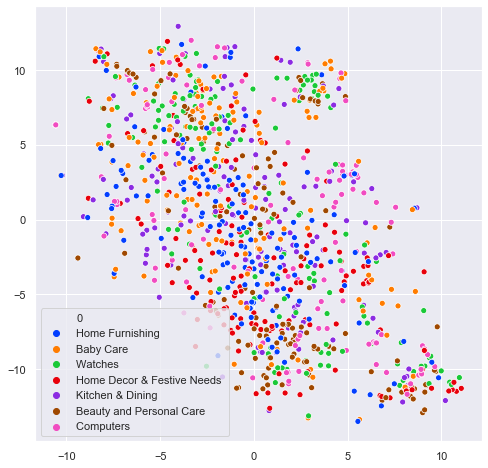

In [597]:
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_ORB[:, 0], X_tsne_ORB[:, 1],
                hue=Class[0], legend='full', palette=pal)

Normalized confusion matrix


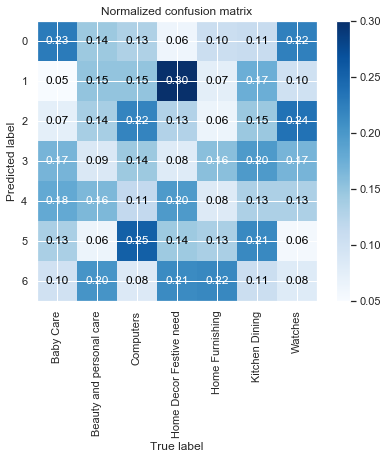

In [598]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
label = Class['Class']

plot_confusion_matrix(PredNMF, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [599]:
ari_ORB_NMF = adjusted_rand_score(label, PredNMF)
ari_ORB_NMF

0.025274979022613914

### 9 - [Regroupement des features issue de TF-IDF et VGG16](#9)<a class="anchor" id="9"></a>

In [600]:
df_best_text_image = pd.concat([df_tfidf, df_vgg16], axis=1)
df_best_text_image

0     1     2     3        4     5     6     7     8     9     10    \
0      0.0   0.0   0.0   0.0  0.17863   0.0   0.0   0.0   0.0   0.0   0.0   
1      0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
2      0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
3      0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
4      0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
...    ...   ...   ...   ...      ...   ...   ...   ...   ...   ...   ...   
1045   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
1046   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
1047   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
1048   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   
1049   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   

      11    12    13    14        15    16    17    18    19    20    21    \
0      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
1      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
2      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
3      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
4      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
...    ...   ...   ...   ...       ...   ...   ...   ...   ...   ...   ...   
1045   0.0   0.0   0.0   0.0  0.042778   0.0   0.0   0.0   0.0   0.0   0.0   
1046   0.0   0.0   0.0   0.0  0.121179   0.0   0.0   0.0   0.0   0.0   0.0   
1047   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
1048   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
1049   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   

      22    23    24        25    26    27        28    29    30    31    \
0      0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
1      0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
2      0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
3      0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
4      0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
...    ...   ...   ...       ...   ...   ...       ...   ...   ...   ...   
1045   0.0   0.0   0.0  0.079123   0.0   0.0  0.083655   0.0   0.0   0.0   
1046   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
1047   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
1048   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
1049   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   

      32        33    34    35    36        37    38    39    40    41    \
0      0.0  0.000000   0.0   0.0   0.0  0.070697   0.0   0.0   0.0   0.0   
1      0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
2      0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
3      0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
4      0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
...    ...       ...   ...   ...   ...       ...   ...   ...   ...   ...   
1045   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
1046   0.0  0.075055   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
1047   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
1048   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
1049   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   

      42    43    44        45        46        47    48    49    50    51    \
0      0.0   0.0   0.0  0.000000  0.070697  0.060839   0.0   0.0   0.0   0.0   
1      0.0   0.0   0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   
2      0.0   0.0   0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0  

In [601]:
# Use NMF to cluster feature .
nmf_output_best_ti = nmf.fit_transform(df_best_text_image)
nmf_output_best_ti.shape

(1050, 7)

In [602]:
# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(Documents))]

# Make the pandas dataframe
df_best_ti_nmf = pd.DataFrame(np.round(nmf_output_best_ti, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
PredNMF = np.argmax(df_best_ti_nmf.values, axis=1)
df_best_ti_nmf['PredNMF'] = PredNMF

In [603]:
tsne_best_ti = TSNE(n_jobs=-1, perplexity=120)
X_tsne_best_ti = tsne_LDA.fit_transform(df_best_text_image)

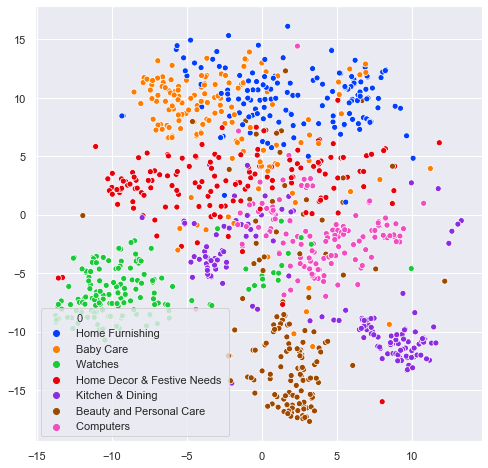

In [604]:
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_best_ti[:, 0], X_tsne_best_ti[:, 1],
                hue=Class[0], legend='full', palette=pal)

Normalized confusion matrix


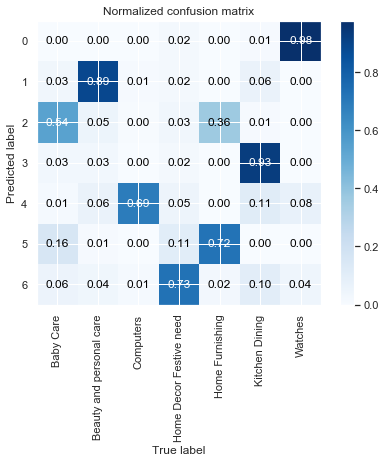

In [605]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6]
label = Class['Class']

plot_confusion_matrix(PredNMF, label, classesx=Classx,
                     classesy=class_names, normalize=True)
plt.show()

In [606]:
ari_best_ti_NMF = adjusted_rand_score(label, PredNMF)
ari_best_ti_NMF

0.542094066934703